In [1]:
!pip install pandas matplotlib seaborn statsmodels scikit-learn openpyxl

1. Install necessary libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

2. Import Dataset

In [3]:
from google.colab import files
uploaded = files.upload()

Saving RBRTEd.xlsx to RBRTEd.xlsx


3. Load and preprocess the data


In [4]:
file_name = list(uploaded.keys())[0]  # Get the uploaded filename
df = pd.read_excel(file_name, skiprows=2, names=["Date", "Price"])
df.dropna(inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
df.dropna(inplace=True)
df.set_index("Date", inplace=True)

4. EDA - Plot the original time series

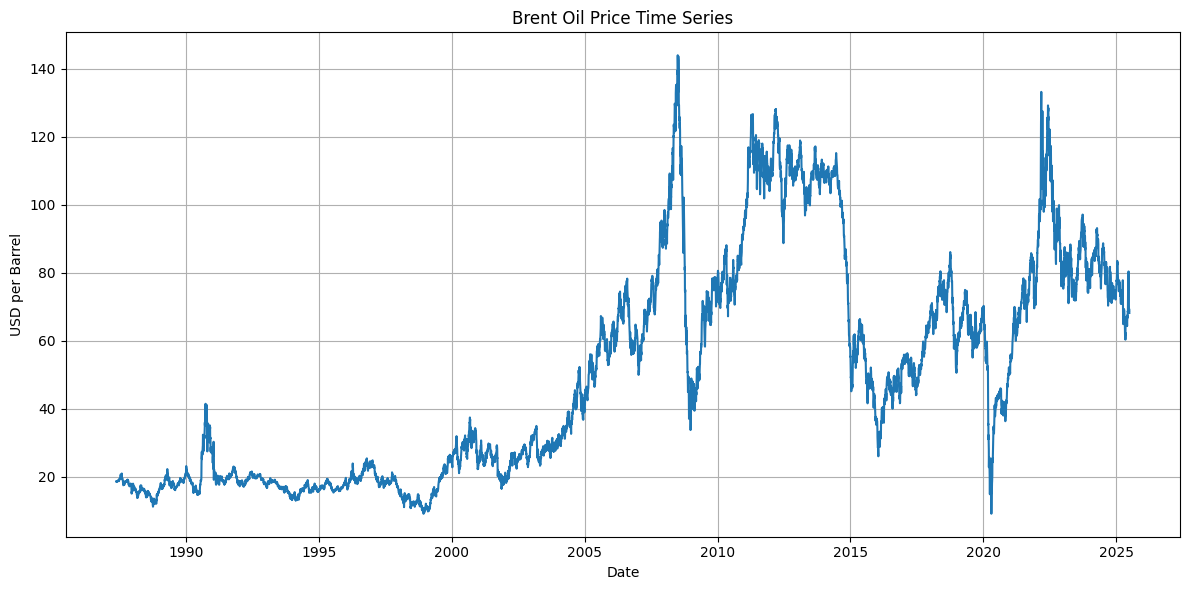

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y="Price")
plt.title("Brent Oil Price Time Series")
plt.xlabel("Date")
plt.ylabel("USD per Barrel")
plt.grid(True)
plt.tight_layout()
plt.show()


5. Check stationarity using ADF test

In [6]:
result = adfuller(df["Price"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -2.239342112558178
p-value: 0.19227753432930816


6. Differencing to make series stationary

In [7]:
df["Price_diff"] = df["Price"].diff()
df.dropna(inplace=True)
result_diff = adfuller(df["Price_diff"])
print("Differenced ADF Statistic:", result_diff[0])
print("Differenced p-value:", result_diff[1])

Differenced ADF Statistic: -16.416388561778035
Differenced p-value: 2.5548627983038945e-29


7. Plot ACF and PACF

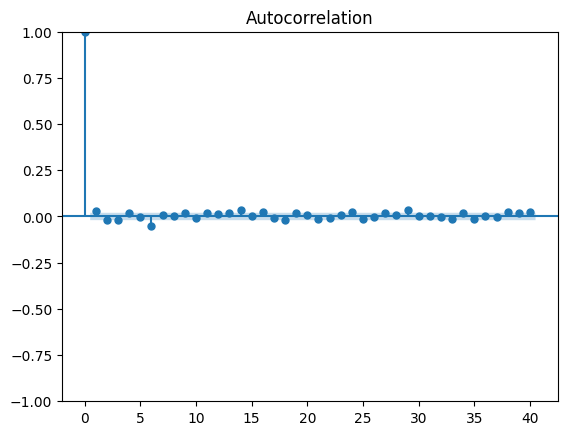

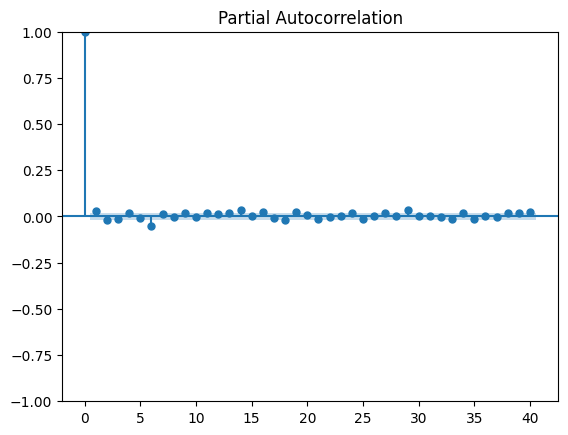

In [8]:
plot_acf(df["Price_diff"], lags=40)
plt.show()
plot_pacf(df["Price_diff"], lags=40)
plt.show()

8. Fit ARIMA model

In [9]:
model = ARIMA(df["Price"], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9669
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -15814.582
Date:                Sun, 06 Jul 2025   AIC                          31635.164
Time:                        23:30:24   BIC                          31656.694
Sample:                             0   HQIC                         31642.464
                               - 9669                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1979      0.159     -1.244      0.214      -0.510       0.114
ma.L1          0.2315      0.158      1.464      0.143      -0.078       0.541
sigma2         1.5429      0.008    181.954      0.0

9. Forecast the next 24 months

In [10]:
forecast = model_fit.get_forecast(steps=24)
forecast_df = forecast.summary_frame()
forecast_df = forecast_df.astype(float)  # Ensure numeric format

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [11]:
# Create future dates for plotting
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=25, freq='M')[1:]

/tmp/ipython-input-11-2529089324.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=25, freq='M')[1:]


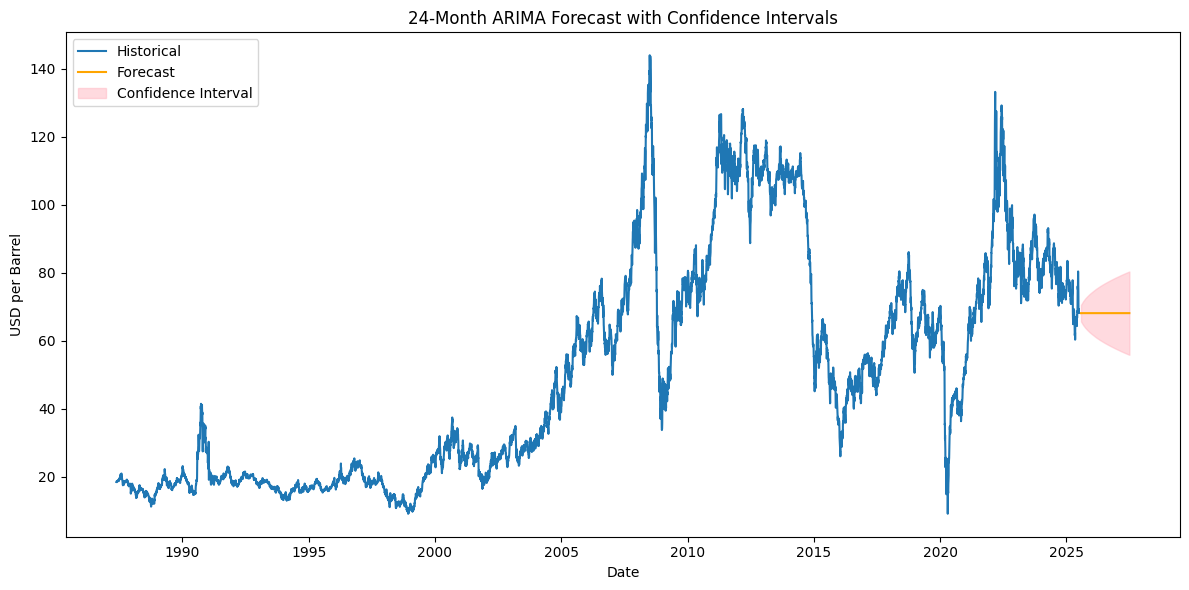

In [12]:
# Plot forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Price"], label="Historical")
plt.plot(future_dates, forecast_df["mean"].values, label="Forecast", color='orange')
plt.fill_between(future_dates, forecast_df["mean_ci_lower"].values, forecast_df["mean_ci_upper"].values,
                 color='lightpink', alpha=0.5, label="Confidence Interval")
plt.title("24-Month ARIMA Forecast with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("USD per Barrel")
plt.legend()
plt.tight_layout()
plt.show()

10. Evaluate model using RMSE (optional)

In [13]:
train = df.iloc[:-24]
test = df.iloc[-24:]
model_train = ARIMA(train["Price"], order=(1, 1, 1))
model_train_fit = model_train.fit()
preds = model_train_fit.forecast(steps=24)
rmse = np.sqrt(mean_squared_error(test["Price"], preds))
print(f"RMSE on last 24 months: {rmse:.2f}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RMSE on last 24 months: 7.91


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


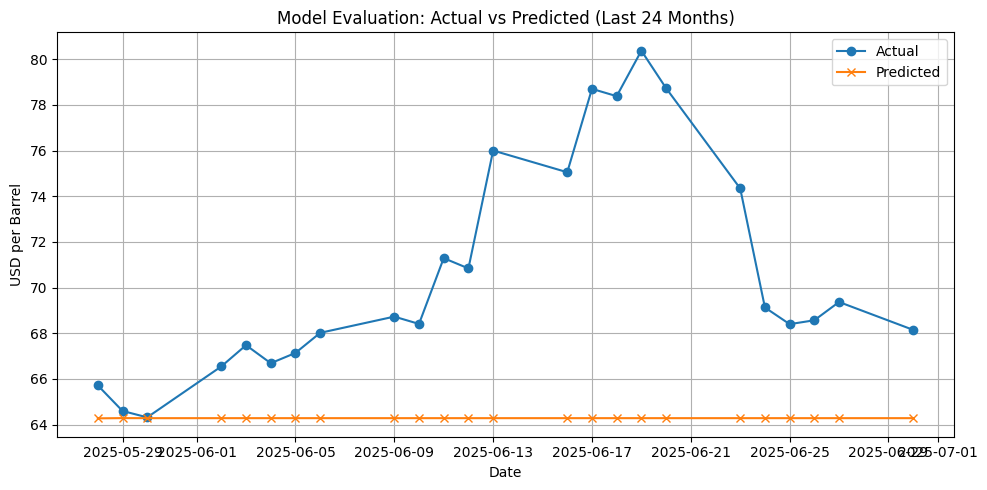

In [15]:
# RMSE Plot
plt.figure(figsize=(10, 5))
plt.plot(test.index, test["Price"], label="Actual", marker='o')
plt.plot(test.index, preds, label="Predicted", marker='x')
plt.title("Model Evaluation: Actual vs Predicted (Last 24 Months)")
plt.xlabel("Date")
plt.ylabel("USD per Barrel")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()